# Anticipez les besoins en consommations de bâtiments

## Étape 5 : Optimisez et interprétez le modèle

### Reprendre les éléments de notre notebook de l'étape 4

* J'importe les librairies nécessaires

In [1]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate, 
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
building_cv = pd.read_csv("Data/Projet_3_etape4_clean.csv")

* Petit récapitulatif

In [3]:
data_avant_transformation = building_cv.shape
print('Nous retrouvons',data_avant_transformation[0],'lignes et nous avons',data_avant_transformation[1],'colonnes avant le nettoyage des données avant transformation.')

Nous retrouvons 1601 lignes et nous avons 48 colonnes avant le nettoyage des données avant transformation.


### Recommendation 1 : Utiliser la méthode GridSearchCV importée plus haut dans le Notebook et regarder la documentation de scikit-learn sur cette méthode afin de bien l'adapter à votre usage.

#### Afin d'utiliser la fonction GridSearchCV sur le modèle, on va le faire étape par étape

#### Nous devons tester la validation croisée sur notre meilleur modèle. A l'étape précédente nous avons vu que c'était celui de RandomForestRegressor

* J'enregistre mes colonnes

In [4]:
numerical_cols = [
    'NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking',
    'NbSourcesEnergies','SecondUseRatio',
    'ThirdUseRatio','AreaPerFloor']

encoded_cols = [
    'HasSteam','HasElectricity','HasGas','PrimaryPropertyType_Distribution_Center','PrimaryPropertyType_Hospital',
    'PrimaryPropertyType_Hotel','PrimaryPropertyType_K_12_School','PrimaryPropertyType_Laboratory','PrimaryPropertyType_Large_Office',
    'PrimaryPropertyType_Medical_Office','PrimaryPropertyType_Mixed_Use_Property','PrimaryPropertyType_Office','PrimaryPropertyType_Other',
    'PrimaryPropertyType_Refrigerated_Warehouse','PrimaryPropertyType_Residence_Hall','PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail_Store',
    'PrimaryPropertyType_Self_Storage_Facility','PrimaryPropertyType_Senior_Care_Community','PrimaryPropertyType_Small_and_Mid_Sized_Office',
    'PrimaryPropertyType_Supermarket_Grocery_Store','PrimaryPropertyType_University','PrimaryPropertyType_Warehouse','PrimaryPropertyType_Worship_Facility',
    'Neighborhood_BALLARD','Neighborhood_CENTRAL','Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN','Neighborhood_EAST','Neighborhood_GREATER_DUWAMISH',
    'Neighborhood_LAKE_UNION','Neighborhood_MAGNOLIA_QUEENANNE','Neighborhood_NORTH','Neighborhood_NORTHEAST','Neighborhood_NORTHWEST','Neighborhood_SOUTHEAST',
    'Neighborhood_SOUTHWEST','UsageType_Bin','AgeGroup'
]

* Je sépare X et y (target déjà en log)


In [5]:
y = building_cv["SiteEnergyUse_log"]
X = building_cv.drop(columns=["SiteEnergyUse_log"])

* Je split mon jeu en apprentissage et en test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

* Je standardise ma liste numerical_cols et je laisse intact celle déjà encodée

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', 'passthrough', encoded_cols)
    ])

* J'ajoute la fonction Pipeline pour faire indiquer le modèle que je veux lancer en ajoutant mon DataFrame reconstitué. En scikit-learn, une pipeline est un objet qui enchaîne plusieurs étapes de traitement et un modèle en un seul bloc. Elle sert à automatiser le workflow de machine learning et à éviter de refaire les transformations à la main à chaque fois.

In [8]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

* J'indique mes hyperparamètres

In [9]:
param_grid = {
    'model__n_estimators': [50, 100], # Le nombre d’arbres dans la forêt aléatoire
    'model__max_depth': [None, 10, 20], # La profondeur maximale des arbres
    'model__min_samples_leaf': [1, 2, 4] # Le nombre minimum d’échantillons dans une feuille
    
}

* Je remplis la fonction GridSearchCV

In [10]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error', # Le  scoring définit la métrique utilisée pour évaluer les modèles à chaque fold. On peut en mettre qu'un
    n_jobs=-1, # Le nombre de processeurs à utiliser pour exécuter le GridSearchCV. Ici c'est tout les CPU
    verbose=2 # Contrôle le niveau d’affichage des informations pendant l’exécution
)

* J'entraîne le modèle

In [11]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=50; total time=   0.7s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=50; total time=   0.7s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=50; total time=   0.7s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=50; total time=   0.8s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=50; total time=   0.8s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__n_estimators=50; total time=   0.5s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=100; total time=   1.5s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=100; total time=   1.6s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=100; total time=   1.6s
[CV] END model__ma

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [None, 10, ...], 'model__min_samples_leaf': [1, 2, ...], 'model__n_estimators': [50, 100]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


* J'enregistre quel est le meilleur modèle, je réalise la prédiction et j'évalue

In [12]:
best_model = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur RMSE :", -grid_search.best_score_)

Meilleurs paramètres : {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}
Meilleur RMSE : 0.6670102643620368


#### Maintenant que nous avons trouvé les meilleurs paramètres de notre modèle, nous pouvons l'appliquer à notre cross validate de l'étape 4, afin de réaliser une comparaison.

In [15]:
# J'enregsitre mes colonnes
numerical_cols = [
    'NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking',
    'NbSourcesEnergies','SecondUseRatio',
    'ThirdUseRatio','AreaPerFloor']

encoded_cols = [
    'HasSteam','HasElectricity','HasGas','PrimaryPropertyType_Distribution_Center','PrimaryPropertyType_Hospital',
    'PrimaryPropertyType_Hotel','PrimaryPropertyType_K_12_School','PrimaryPropertyType_Laboratory','PrimaryPropertyType_Large_Office',
    'PrimaryPropertyType_Medical_Office','PrimaryPropertyType_Mixed_Use_Property','PrimaryPropertyType_Office','PrimaryPropertyType_Other',
    'PrimaryPropertyType_Refrigerated_Warehouse','PrimaryPropertyType_Residence_Hall','PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail_Store',
    'PrimaryPropertyType_Self_Storage_Facility','PrimaryPropertyType_Senior_Care_Community','PrimaryPropertyType_Small_and_Mid_Sized_Office',
    'PrimaryPropertyType_Supermarket_Grocery_Store','PrimaryPropertyType_University','PrimaryPropertyType_Warehouse','PrimaryPropertyType_Worship_Facility',
    'Neighborhood_BALLARD','Neighborhood_CENTRAL','Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN','Neighborhood_EAST','Neighborhood_GREATER_DUWAMISH',
    'Neighborhood_LAKE_UNION','Neighborhood_MAGNOLIA_QUEENANNE','Neighborhood_NORTH','Neighborhood_NORTHEAST','Neighborhood_NORTHWEST','Neighborhood_SOUTHEAST',
    'Neighborhood_SOUTHWEST','UsageType_Bin','AgeGroup'
    ]

# Je sépare X et y (target déjà en log)
y = building_cv["SiteEnergyUse_log"]
X = building_cv.drop(columns=["SiteEnergyUse_log"])

# Scaling uniquement des colonnes numériques
scaler = StandardScaler()
X_scaled_num = scaler.fit_transform(X[numerical_cols])

# On applique StandardScaler seulement aux colonnes numériques
# On laisse passer les colonnes encodées sans modification (pas besoin de scaler)
# Utilisation de ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', 'passthrough', encoded_cols)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        random_state=42, max_depth=None,
        min_samples_leaf=1, n_estimators=100
        ))
])

# Fonctions inversées pour avoir nos valeurs brutes dans nos scores
def rmse_original(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae_original(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return mean_absolute_error(y_true, y_pred)

def mape_original(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return mean_absolute_percentage_error(y_true, y_pred)

def r2_original(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return r2_score(y_true, y_pred)
scoring = {
    'RMSE': make_scorer(rmse_original, greater_is_better=False),
    'MAE': make_scorer(mae_original, greater_is_better=False),
    'MAPE': make_scorer(mape_original, greater_is_better=False),
    'R2': make_scorer(r2_original, greater_is_better=False),

}


# Cross-validation pour le modèle
results_all = []

cv_results = cross_validate(
    pipeline,
    X,
    y,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# Stockage des résultats pour RandomForest
results_all.append({
     "Modèle": "RandomForest",
     "RMSE": f"{-cv_results['test_RMSE'].mean():.2f} ± {cv_results['test_RMSE'].std():.2f}",
     "MAE": f"{-cv_results['test_MAE'].mean():.2f} ± {cv_results['test_MAE'].std():.2f}",
     "MAPE (%)": f"{-cv_results['test_MAPE'].mean()*100:.2f} ± {cv_results['test_MAPE'].std()*100:.2f}",
     "R2": f"{cv_results['test_R2'].mean():.2f} ± {cv_results['test_R2'].std():.2f}"
})

df_results = pd.DataFrame(results_all)
print(df_results)

         Modèle                     RMSE                      MAE  \
0  RandomForest  7830894.39 ± 3072859.70  3214777.05 ± 1674994.73   

        MAPE (%)            R2  
0  62.95 ± 10.02  -0.57 ± 0.14  


Comparaison avec et sans optimisation des hyperparamètres :

Métrique : ancien modèle vs optimisé
* RMSE : 7 831 897 ± 3 073 800 vs 7 830 894 ± 3 072 860
* MAE : 3 214 481 ± 1 675 085 vs 3 214 777 ± 1 674 994
* MAPE : 62,94 % ± 10,02 vs 62,95 % ± 10,02
R2 : -0,57 ± 0,14 vs -0,57 ± 0,14

Interprétation des résultats vs le modèle à l'étape 4 sans optimisation des hyperparamètres
* Pas de changement significatif : les performances restent quasiment identiques après optimisation.
* RMSE et MAE montrent que le modèle peut seulement prédire une partie des bâtiments.
* MAPE (~63%) : le modèle fait en moyenne une erreur de 63 % par rapport aux vraies valeurs, ce qui est compréhensible vu les valeurs très grandes et disparates.
* R2 négatif : reste le même, à cause des gros consommateurs qui dominent la métrique après re-transformation des logs.
* L’optimisation des hyperparamètres n’a pas apporté d’amélioration notable dans ce cas. Le RandomForest initial est correct pour ce type de données avec de fortes valeurs extrêmes.

Interprétation des écarts type :
* RMSE et MAE : L’écart-type est très proche entre ancien et optimisé. Le modèle optimisé n’a pas rendu le modèle plus stable sur les différents sous-ensembles de données.
* MAPE : Écart-type identique → le modèle n’a pas réduit la variation relative des erreurs, même après optimisation.

Conclusion :
* Les améliorations du modèle optimisé sont négligeables sur ces métriques et leur variabilité.
* Les écarts-types montrent que la stabilité du modèle n’a pas été impactée par l’optimisation.
Le problème ne se situe pas forcément dans l’algorithme ou l’hyperparamétrage, mais plutôt dans :
	1.	La qualité des features (besoin de plus de caractéristiques différentes)
	3.	La distribution très dispersée de la consommation, même après log.

### Recommendation 2 : Il est coutume de représenter la feature importance sous forme d’un histogramme.

#### Feature importance : Création d'un tableau récapitulatif

* La Feature Importance consiste à estimer de manière objective l’utilité d’une caractéristique. Cette démarche peut s’avérer utile pour sélectionner les caractéristiques. Chacune d’entre elles reçoit un score, et elles peuvent ainsi être classées en fonction de leurs scores. Celles avec le plus haut score peuvent être choisies pour être incluses dans l’ensemble de données.

In [16]:
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

importances = model.feature_importances_
feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importances_df.nlargest(15,'importance'))

                                          feature  importance
2                                PropertyGFATotal    0.654746
10                                   AreaPerFloor    0.047330
30                  PrimaryPropertyType_Warehouse    0.036338
28  PrimaryPropertyType_Supermarket_Grocery_Store    0.031760
8                                  SecondUseRatio    0.023829
25      PrimaryPropertyType_Self_Storage_Facility    0.020738
7                               NbSourcesEnergies    0.016327
46                                       AgeGroup    0.014758
20                      PrimaryPropertyType_Other    0.013715
9                                   ThirdUseRatio    0.010388
3                              PropertyGFAParking    0.009655
11        PrimaryPropertyType_Distribution_Center    0.009279
1                                  NumberofFloors    0.008715
6                                          HasGas    0.008046
15                 PrimaryPropertyType_Laboratory    0.007846


* On voit une dépendance énorme à la varibale de PropertyGFATotal. Notre target est la consommation d'énergie des bâtiments donc ce n'est pas surprenant, la consommation dépend beaucoup de la taille.

#### Représentation graphique des caractéristiques les plus utiles

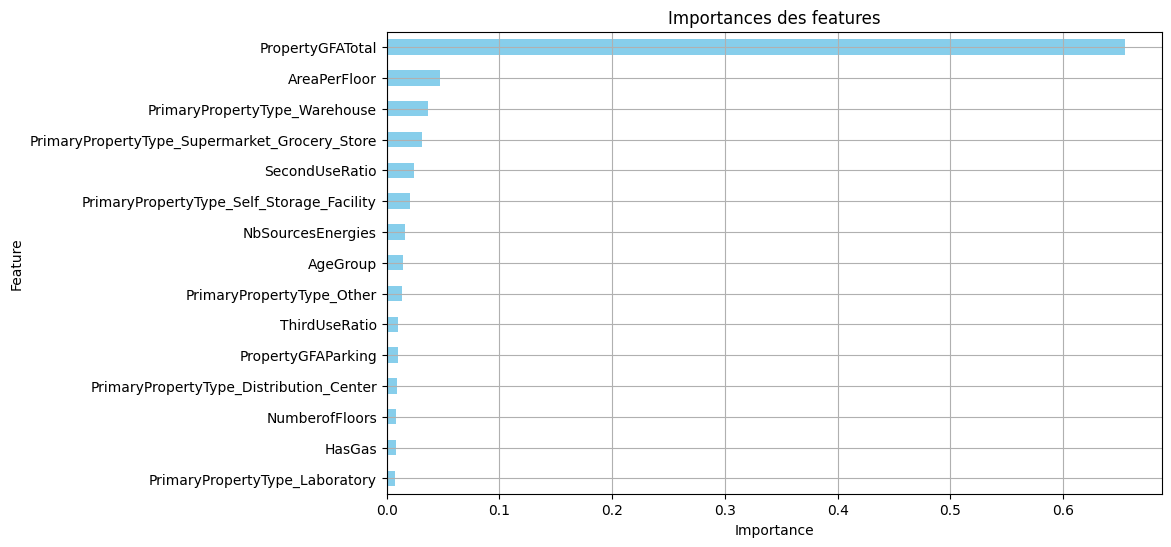

In [17]:
top_features = feature_importances_df.nlargest(15, 'importance')
top_features.sort_values(by="importance", ascending=True).plot(
    x="feature",
    y="importance",
    kind="barh",
    legend=False,
    figsize=(10,6),
    color="skyblue"
)

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Importances des features")
plt.grid()
plt.show()

* On réalise encore plus l'impact de PropertyGFATotal.
* AreaPerFloor représente aussi une feature importante.
* Quelques types de bâtiments comme Warehouse ou GroceryStore expliquent une partie du modèle.
* Dans le top 15 on ne retrouve pas de notion de Quartier.
* On peut noter que l'on retrouve quelques ratios que nous avons créé qui se retrouvent dans les plus utiles comme SecondUseRatio/ NbSourcesEnergies/ AgeGroup/ ThirdUseRatio et HasGas